# Previsão de Preços de Tomate no Atacado

## Equipe
 - Álvaro Alvim Alfredo Lopes
 - Arilson Xavier de Souza Costa
 - Matheus Magalhães de Paula Paiva
 - Tainara de Cássia Martins

## Contexto

Este trabalho busca encontrar uma solução que faz a previsão de preços para tomates vendidos por produtores(atacado). Como forma de auxiliar agricultores a tomarem a melhor decisão durante o ciclo de sua lavoura.

Para isso será elaborado um modelo que com base em dados passados, como o próprio preço e o clima, buscará predizer valores futuros para o preço do tomate.

Dessa forma foi feito a análises do cenário de produção de tomate e suas variáveis. Como por exemplo a escolha de regiões, tipos de produtos e verificações da produção.

## Questão de Negócios

Durante o ciclo de uma lavoura o preço do tomate tende a oscilar periodicamente, de modo que para o agricultor é difícil de projetar resultados da sua lavoura de maneira precisa, o que dificulta a gestão de sua lavoura no dia a dia.

Com base nisso o nosso modelo busca entregar uma solução que possa orientar o agricultor tanto na projeção de resultado como também de maneira estratégica para a gestão da lavoura.


## Importações

In [200]:
import pandas as pd
import numpy as np
import matplotlib as plt
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import warnings
warnings.filterwarnings('ignore')


## Bases de Dados

A base de dados utilizada nesse projeto, pode ser encontrada no site da [HF Brasil](https://www.hfbrasil.org.br/br/banco-de-dados-precos-medios-dos-hortifruticolas.aspx). HF Brasil é parte do CEPEA - Centro de Estudos Avançados em Economia Aplicada, da ESALQ - Escola Superior de Agricultura "Luiz de Queiroz", reúne pesquisadores e analistas de mercados, dedicados aos aspectos econômicos dos setores de frutas e hortaliças. Possui como missão produzir informações de qualidade pautadas em valores como imparcialidade e ética,que contribuam para o desenvolvimento sustentável dos setores estudados.

Também foi utilizado para este trabalho os dados cimáticos adquiridos do Banco de Dados Meteorológicos do INMET - [Instituto Nacional de Metereologia](https://portal.inmet.gov.br/dadoshistoricos), responsável por monitorar, analisar e prever situações climáticas. O sistema de coleta e distribuição de dados metereológicos do instituto é dotado de estações de sondagem de ar superior, estações metereológicas de superfície e a maior rede de estações metereológicas da América do Sul.

### Sobre as bases de dados
A base de dados inicialmente utilizada foi um arquivo gerado direto do site da HF Brasil, em formato .xlsx, que trazia de maneira geral informações sobre a venda de tomate no atacado no período de janeiro de 2015 á abril de 2023, essa base de dados continha as informações de Produto, Região, Dia, Mês, Ano, Moeda, Unidade e Preço.

Sobre os dados de clima, eles foram coletados de relátórios anuais da estação metereológica de Barretos, sendo assim ele foi preveamente tratado, e transformado em um arquivo .csv, com as informações de Data, Umidade, Temperatura e Precipitação. Porém foi visto ainda que a base de dados, possui dados faltantes e fora de escala. Dessa forma ele ainda foi tratado neste trabalho novamente.

Abaixo segue os dataframes das bases de dados utilizadas.

In [147]:
df = pd.read_excel('tomate-precos-medios.xlsx')
display(df)
clima = pd.read_csv('clima.csv')
display(clima)

,Produto,Região,Dia,Mês,Ano,Moeda,Unidade,Preço
0,Italiano - atacado,Campinas,14,4,2023,R$,Caixa 20 kg,86.67
1,Italiano - atacado,São Paulo (capital),14,4,2023,R$,Caixa 20 kg,65.00
2,Italiano 3A AT - Tomate,Campinas,14,4,2023,R$,Caixa 20 kg,150.00
3,Italiano 3A AT - Tomate,Rio de Janeiro (capital),14,4,2023,R$,Caixa 20 kg,100.00
4,Italiano 3A AT - Tomate,São Paulo (capital),14,4,2023,R$,Caixa 20 kg,113.33
...,...,...,...,...,...,...,...,...
32853,Salada longa vida AA - atacado,Rio de Janeiro (capital),2,1,2015,R$,Caixa 20 kg,31.75
32854,Salada longa vida AA - atacado,São Paulo (capital),2,1,2015,R$,Caixa 20 kg,31.38
32855,Salada longa vida AA - produtor,Itapeva (região),2,1,2015,R$,Caixa Aberta,26.67
32856,Santa Cruz AA - atacado,Campinas,2,1,2015,R$,Caixa 20 kg,31.00


,Data,Precipitacao,Temperatura,Umidade
0,2015-01-01,0.325000,27.479167,78.958333
1,2015-01-02,0.125000,26.537500,79.625000
2,2015-01-03,0.033333,26.270833,76.458333
3,2015-01-04,0.983333,24.508333,88.666667
4,2015-01-05,0.000000,21.845833,76.541667
...,...,...,...,...
3068,2023-05-27,0.000000,21.209091,65.318182
3069,2023-05-28,0.000000,21.227273,67.045455
3070,2023-05-29,0.000000,21.262500,71.791667
3071,2023-05-30,0.216667,20.420833,73.041667


Porém devido as necessidades do projeto essa base de dados foi alterada e reutilizada como será visto mais a frente.

## Análise Exploratória dos Dados

Inicialmente foi feito uma análise exploratória dos dados buscando verificar a qualidade dos dados. Também foi feito as customizações necessárias tal como a limpeza e verificação das características dos dados. Após isso foi feito a análise dos dados.

### Qualidade dos Dados

In [148]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32858 entries, 0 to 32857
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Produto  32858 non-null  object 
 1   Região   32858 non-null  object 
 2   Dia      32858 non-null  int64  
 3   Mês      32858 non-null  int64  
 4   Ano      32858 non-null  int64  
 5   Moeda    32858 non-null  object 
 6   Unidade  32858 non-null  object 
 7   Preço    32858 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.0+ MB


None

,Dia,Mês,Ano,Preço
count,32858.000000,32858.000000,32858.000000,32858.000000
mean,15.701990,6.439802,2018.679713,48.524204
std,8.706996,3.310749,2.311127,24.767364
min,1.000000,1.000000,2015.000000,7.000000
25%,8.000000,4.000000,2017.000000,30.000000
50%,16.000000,6.000000,2019.000000,43.330000
75%,23.000000,9.000000,2021.000000,61.670000
max,31.000000,12.000000,2023.000000,195.000000


### Limpeza dos dados e Customização

In [149]:
def escalona_df(df):
    '''
    Converte a coluna de Data para o formato DataTime e ordena o DataFrame
    '''
    df.drop_duplicates(inplace = True)
    df.astype({'Dia':'int32','Mês':'int32','Ano':'int32'})
    df = df.astype({'Dia':str,'Mês':str,'Ano':str})
    df['Data'] = df[['Dia','Mês','Ano']].agg('-'.join,axis=1)
    df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
    df = df.sort_values(by=["Região","Produto","Unidade","Data"])
    return df
def aumento_e_acelaracao(df):
    '''
    Cria as campos de Aumento e Aceleração, de acordo com a variação prévia do
    Preço
    '''
    regioes = np.array(df['Região'].unique())
    produtos = np.array(df['Produto'].unique())
    unidades = np.array(df['Unidade'].unique())
    df_list = []
    for regiao in regioes:
        for produto in produtos:
            for unidade in unidades:
                df_aux = df.loc[(df["Unidade"] == unidade) & (df['Produto'] == produto) & (df['Região'] == regiao)].reset_index()
                df_aux['Aumento'] = df_aux['Preço'].diff()
                df_aux['Aceleracao'] = df_aux['Aumento'].diff()
                df_list.append(df_aux)
    columns = df.columns
    df_tratado = pd.DataFrame(columns=columns)
    for dataframe in df_list:
        if dataframe.shape[0] > 10:
            df_tratado = pd.concat([df_tratado,dataframe],ignore_index=True)
    return df_tratado

In [150]:
# Chama as funções criadas acima
df = escalona_df(df)
df = aumento_e_acelaracao(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32731 entries, 0 to 32730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Produto     32731 non-null  object        
 1   Região      32731 non-null  object        
 2   Dia         32731 non-null  object        
 3   Mês         32731 non-null  object        
 4   Ano         32731 non-null  object        
 5   Moeda       32731 non-null  object        
 6   Unidade     32731 non-null  object        
 7   Preço       32731 non-null  float64       
 8   Data        32731 non-null  datetime64[ns]
 9   index       32731 non-null  float64       
 10  Aumento     32701 non-null  float64       
 11  Aceleracao  32671 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 3.0+ MB


### Estudo dos Dados

Verificação das Regiões

São Paulo (capital)         9868
Campinas                    6693
Rio de Janeiro (capital)    3772
Belo Horizonte (capital)    2254
Venda Nova do Imigrante     2000
Araguari                    1478
Paty do Alferes (região)    1261
Mogi Guaçu (região)         1024
Chapada Diamantina          1015
Itapeva (região)             965
Sumaré (região)              821
São José de Ubá (região)     677
Caçador (região)             643
Norte do Paraná              260
Name: Região, dtype: int64


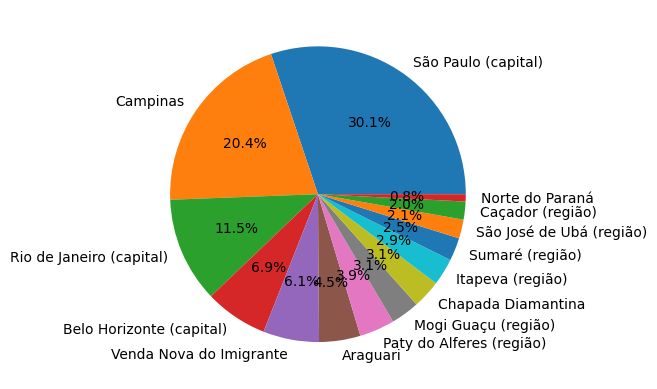

In [151]:
# Plota um gráfico com a distribuição das Regiões de acordo com os dados
regiao_dist = df['Região'].value_counts()
print(regiao_dist)
plt.pie(regiao_dist,labels=regiao_dist.index,autopct='%1.1f%%')
plt.show()

Com o gráfico acima é visto que mais de 30% dos valores estão concentrados na região de São Paulo. Dessa forma seguiremos somente com a regia de São Paulo visto que o peso dos preços nesta região é maior e mais preciso.

Verificação das Unidades, com relação as Regiões selecionadas

In [152]:
# Separa o dataframe pegando apenas a região de São Paulo
df_sp = df.loc[df['Região']=="São Paulo (capital)"].sort_values(by=["Produto","Data"])

São Paulo: Caixa 20 kg    9868
Name: Unidade, dtype: int64


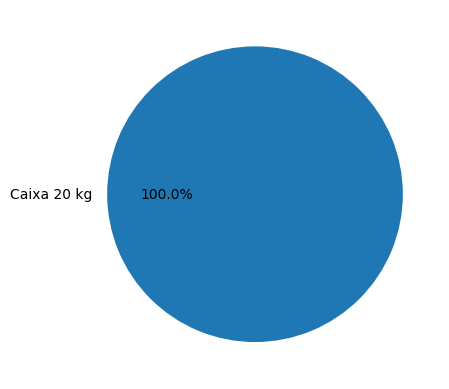

In [153]:
# Plota um gráfico com a distribuição das Unidades de acordo com os dados de São Paulo
regiao_dist = df['Região'].value_counts()
unidade_dist_sp = df_sp['Unidade'].value_counts()
print(f"São Paulo: {unidade_dist_sp}")
plt.pie(unidade_dist_sp,labels=unidade_dist_sp.index,autopct='%1.1f%%')
plt.show()

Como visto há apenas unidades do tipo "Caixa 20Kg"

Verificação quanto aos produtos relacionado com os Anos das amostras

In [154]:
# Plota um Histograma distribuido por Ano e dividito por Produto
regiao_dist = df['Região'].value_counts()
produto_dist_sp = df_sp['Produto'].value_counts()
print(f"São Paulo: {produto_dist_sp}")
fig = px.histogram(df_sp, x='Ano',color='Produto',text_auto=True,width=1000, height=500)
fig.update_layout(title = "Distribuição de valores disponíveis por Ano em São Paulo")
fig.show()

São Paulo: Salada longa vida AA - atacado    2007
Italiano - atacado                2003
Italiano 3A AT - Tomate           1720
Salada 3A AT - Tomate             1720
Santa Cruz AA - atacado           1313
Santa Cruz 3A AT - Tomate         1042
Rasteiro - atacado                  63
Name: Produto, dtype: int64


Como verificado apenas os Produtos dos Tipos "Italiano - atacado" e "Salada longa Vida AA - atacado" estão presentes na região de São Paulo e em todos os anos. Dessa forma será prosseguido somente com essas duas qualidades Produto

### Considerações Sobre os Dados

Com as informações acima foi buscado novamente os dados na fonte, dessa vez pegando desde o ano de 2006 até o ano de 2023, utilizando um espaço de tempo maior. Porém no desenvolvimento, será visto que devido a base de dados de clima,
os dados necessitaram ser limitados ao espaço de tempo de 2015 a maio de 2023.

In [155]:
df_sao_paulo = pd.read_excel("tomate-precos-medios-sao-paulo.xlsx")

In [156]:
df_sao_paulo = escalona_df(df_sao_paulo)
df_sao_paulo = aumento_e_acelaracao(df_sao_paulo)
df_sao_paulo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19536 entries, 0 to 19535
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Produto     19536 non-null  object        
 1   Região      19536 non-null  object        
 2   Dia         19536 non-null  object        
 3   Mês         19536 non-null  object        
 4   Ano         19536 non-null  object        
 5   Moeda       19536 non-null  object        
 6   Unidade     19536 non-null  object        
 7   Preço       19536 non-null  float64       
 8   Data        19536 non-null  datetime64[ns]
 9   index       19536 non-null  float64       
 10  Aumento     19529 non-null  float64       
 11  Aceleracao  19522 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 1.8+ MB


In [157]:
df_sao_paulo.head()

,Produto,Região,Dia,Mês,Ano,Moeda,Unidade,Preço,Data,index,Aumento,Aceleracao
0,Italiano - atacado,São Paulo (capital),20,6,2006,R$,Caixa 20 kg,17.67,2006-06-20,17451.0,NaN,NaN
1,Italiano - atacado,São Paulo (capital),21,6,2006,R$,Caixa 20 kg,17.33,2006-06-21,17447.0,-0.34,NaN
2,Italiano - atacado,São Paulo (capital),22,6,2006,R$,Caixa 20 kg,15.00,2006-06-22,17443.0,-2.33,-1.99
3,Italiano - atacado,São Paulo (capital),27,6,2006,R$,Caixa 20 kg,16.50,2006-06-27,17433.0,1.50,3.83
4,Italiano - atacado,São Paulo (capital),29,6,2006,R$,Caixa 20 kg,16.50,2006-06-29,17426.0,0.00,-1.50


### Preparação dos Dados

In [158]:
def calc_media_movel(df):
  '''
  Adiciona ao Dataframe as médias moveis do Preço, Aumento e Aceleração
  '''
  df["Media 5"] = df["Preço"].rolling(window=5).mean()
  df["Media 10"] = df["Preço"].rolling(window=10).mean()
  df["Media 20"] = df["Preço"].rolling(window=20).mean()
  df["Aumento 5"] = df["Aumento"].rolling(window=5).mean()
  df["Aumento 10"] = df["Aumento"].rolling(window=10).mean()
  df["Aumento 20"] = df["Aumento"].rolling(window=20).mean()
  df["Aceleracao 5"] = df["Aceleracao"].rolling(window=5).mean()
  df["Aceleracao 10"] = df["Aceleracao"].rolling(window=10).mean()
  df["Aceleracao 20"] = df["Aceleracao"].rolling(window=20).mean()
  return df

def calc_min_max(df):
  '''
  Adiciona ao Dataframe os valores de màximo e mìnimo dos ultimo 10 preços
  '''
  df["Min 10"] = df["Preço"].rolling(window=10).min()
  df["Max 10"] = df["Preço"].rolling(window=10).max()
  return df

def set_data_index(df):
  '''
  Converte a coluna Data para o tipo DataTime com o formato %Y-%m-%d
  '''
  df['Data'] = pd.to_datetime(df['Data'], format='%Y-%m-%d')
  return df

def convert_columns(df):
  '''
  Converte os campos Dia, Mês e Ano para o tipo inteiro
  '''
  df['Dia'] = pd.to_numeric(df['Dia'])
  df['Mês'] = pd.to_numeric(df['Mês'])
  df['Ano'] = pd.to_numeric(df['Ano'])
  return df

def normaliza_dados(x):
  '''
  Realiza a normalização dos dados que estão fora da faixa
  '''
  if x < 0:
    return np.NAN
  else:
    return x

def clima():
  '''
  Formata a base de dados de Clima, adiciona os valores de climas de 5 dias atrás
  e aplica a normalização feita acima
  '''
  df_clima = pd.read_csv('clima.csv')
  df_clima['Data'] = pd.to_datetime(df_clima['Data'], format='%Y-%m-%d')
  df_clima = df_clima.set_index(pd.DatetimeIndex(df_clima['Data'].values))
  df_clima_ant = pd.read_csv('clima.csv')
  df_clima_ant['Data'] = pd.to_datetime(df_clima_ant['Data'], format='%Y-%m-%d')
  df_clima_ant = df_clima_ant.set_index(pd.DatetimeIndex(df_clima_ant['Data'].values))
  df_clima_ant = df_clima_ant.shift(periods=5)
  df_clima_ant.drop(axis=1,columns=['Data'],inplace=True)
  df_clima_ant = df_clima_ant.rename(columns={
      'Precipitacao':'Precipitacao de 5 dias atras',
      'Temperatura':'Temperatura de 5 dias atras',
      'Umidade':'Umidade de 5 dias atras'
  })
  df_clima = pd.merge(df_clima,df_clima_ant,left_index=True, right_index=True)
  df_clima['Precipitacao'] = df_clima['Precipitacao'].apply(normaliza_dados)
  df_clima['Umidade'] = df_clima['Umidade'].apply(normaliza_dados)
  df_clima['Temperatura'] = df_clima['Temperatura'].apply(normaliza_dados)
  df_clima['Umidade de 5 dias atras'] = df_clima['Umidade de 5 dias atras'].apply(normaliza_dados)
  df_clima['Temperatura de 5 dias atras'] = df_clima['Temperatura de 5 dias atras'].apply(normaliza_dados)
  df_clima['Precipitacao de 5 dias atras'] = df_clima['Precipitacao de 5 dias atras'].apply(normaliza_dados)
  return df_clima

def format_df(df):
  '''
  Formata o dataframe com a funções acima além de adicionar a base de dados do clima
  Tambem executa o tratamento de dados faltantes e remoção de colunas
  '''
  df = calc_media_movel(df)
  df = calc_min_max(df)
  df = convert_columns(df)
  df = set_data_index(df)
  df.drop(axis=1,columns=['index','Moeda','Produto','Região','Unidade','Aumento','Aceleracao'],inplace=True)
  df = df.loc[df['Ano'] > 2014]
  df_clima = clima()
  df = pd.merge(df, df_clima, on='Data')
  df.fillna(method='backfill',inplace=True)
  df.dropna(inplace=True)
  return df

In [159]:
# Separa a base de dados por Produto
df_sp_salada_AA = df_sao_paulo.loc[df_sao_paulo['Produto'] == "Salada longa vida AA - atacado"]
df_sp_italiano = df_sao_paulo.loc[df_sao_paulo['Produto'] == "Italiano - atacado"]

In [160]:
# Efetua as formatações nas base de dados
df_sp_salada_AA = format_df(df_sp_salada_AA)
df_sp_italiano = format_df(df_sp_italiano)

In [161]:
print("Salada AA - atacado")
print(df_sp_salada_AA.info())
print(df_sp_salada_AA.describe())
display(df_sp_salada_AA.head(5))

Salada AA - atacado
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2038 entries, 0 to 2037
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Dia                           2038 non-null   int64         
 1   Mês                           2038 non-null   int64         
 2   Ano                           2038 non-null   int64         
 3   Preço                         2038 non-null   float64       
 4   Data                          2038 non-null   datetime64[ns]
 5   Media 5                       2038 non-null   float64       
 6   Media 10                      2038 non-null   float64       
 7   Media 20                      2038 non-null   float64       
 8   Aumento 5                     2038 non-null   float64       
 9   Aumento 10                    2038 non-null   float64       
 10  Aumento 20                    2038 non-null   float64       
 11  Aceleracao

,Dia,Mês,Ano,Preço,Data,Media 5,Media 10,Media 20,Aumento 5,Aumento 10,...,Aceleracao 10,Aceleracao 20,Min 10,Max 10,Precipitacao,Temperatura,Umidade,Precipitacao de 5 dias atras,Temperatura de 5 dias atras,Umidade de 5 dias atras
0,2,1,2015,31.38,2015-01-02,31.876,29.441,34.0405,0.704,-0.675,...,-0.114,-0.2700,25.00,35.0,0.125000,26.537500,79.625000,0.325000,27.479167,78.958333
1,5,1,2015,36.50,2015-01-05,33.510,30.341,33.5600,1.634,0.900,...,1.575,0.5005,25.00,36.5,0.000000,21.845833,76.541667,0.325000,27.479167,78.958333
2,6,1,2015,40.00,2015-01-06,34.954,31.841,33.3100,1.444,1.500,...,0.600,0.2305,26.67,40.0,0.116667,21.437500,84.000000,0.325000,27.479167,78.958333
3,7,1,2015,56.00,2015-01-07,39.154,34.641,34.2350,4.200,2.800,...,1.300,1.1750,26.67,56.0,0.008333,18.466667,85.375000,0.125000,26.537500,79.625000
4,8,1,2015,46.43,2015-01-08,42.062,36.617,34.3565,2.908,1.976,...,-0.824,-0.8035,27.86,56.0,0.000000,21.350000,60.875000,0.033333,26.270833,76.458333


In [162]:
print("Italiano - atacado")
print(df_sp_italiano.info())
print(df_sp_italiano.describe())
display(df_sp_italiano.head())

Italiano - atacado
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2034 entries, 0 to 2033
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Dia                           2034 non-null   int64         
 1   Mês                           2034 non-null   int64         
 2   Ano                           2034 non-null   int64         
 3   Preço                         2034 non-null   float64       
 4   Data                          2034 non-null   datetime64[ns]
 5   Media 5                       2034 non-null   float64       
 6   Media 10                      2034 non-null   float64       
 7   Media 20                      2034 non-null   float64       
 8   Aumento 5                     2034 non-null   float64       
 9   Aumento 10                    2034 non-null   float64       
 10  Aumento 20                    2034 non-null   float64       
 11  Aceleracao 

,Dia,Mês,Ano,Preço,Data,Media 5,Media 10,Media 20,Aumento 5,Aumento 10,...,Aceleracao 10,Aceleracao 20,Min 10,Max 10,Precipitacao,Temperatura,Umidade,Precipitacao de 5 dias atras,Temperatura de 5 dias atras,Umidade de 5 dias atras
0,2,1,2015,32.00,2015-01-02,32.660,30.030,34.4110,0.566,-0.613,...,-0.291,-0.0970,26.11,35.0,0.125000,26.537500,79.625000,0.325000,27.479167,78.958333
1,5,1,2015,40.00,2015-01-05,34.534,31.280,33.7110,1.874,1.250,...,1.863,-0.0250,26.11,40.0,0.000000,21.845833,76.541667,0.325000,27.479167,78.958333
2,6,1,2015,42.00,2015-01-06,36.600,32.869,33.6235,2.066,1.589,...,0.339,0.6125,27.00,42.0,0.116667,21.437500,84.000000,0.325000,27.479167,78.958333
3,7,1,2015,62.00,2015-01-07,42.000,36.347,34.8665,5.400,3.478,...,1.889,1.3305,27.00,62.0,0.008333,18.466667,85.375000,0.125000,26.537500,79.625000
4,8,1,2015,50.63,2015-01-08,45.326,38.710,35.5410,3.326,2.363,...,-1.115,-0.5685,29.17,62.0,0.000000,21.350000,60.875000,0.033333,26.270833,76.458333


## Modelo

### Tomate Salada AA

array([[<Axes: title={'center': 'Dia'}>, <Axes: title={'center': 'Mês'}>,
        <Axes: title={'center': 'Ano'}>,
        <Axes: title={'center': 'Preço'}>,
        <Axes: title={'center': 'Data'}>],
       [<Axes: title={'center': 'Media 5'}>,
        <Axes: title={'center': 'Media 10'}>,
        <Axes: title={'center': 'Media 20'}>,
        <Axes: title={'center': 'Aumento 5'}>,
        <Axes: title={'center': 'Aumento 10'}>],
       [<Axes: title={'center': 'Aumento 20'}>,
        <Axes: title={'center': 'Aceleracao 5'}>,
        <Axes: title={'center': 'Aceleracao 10'}>,
        <Axes: title={'center': 'Aceleracao 20'}>,
        <Axes: title={'center': 'Min 10'}>],
       [<Axes: title={'center': 'Max 10'}>,
        <Axes: title={'center': 'Precipitacao'}>,
        <Axes: title={'center': 'Temperatura'}>,
        <Axes: title={'center': 'Umidade'}>,
        <Axes: title={'center': 'Precipitacao de 5 dias atras'}>],
       [<Axes: title={'center': 'Temperatura de 5 dias atras'}>,
 

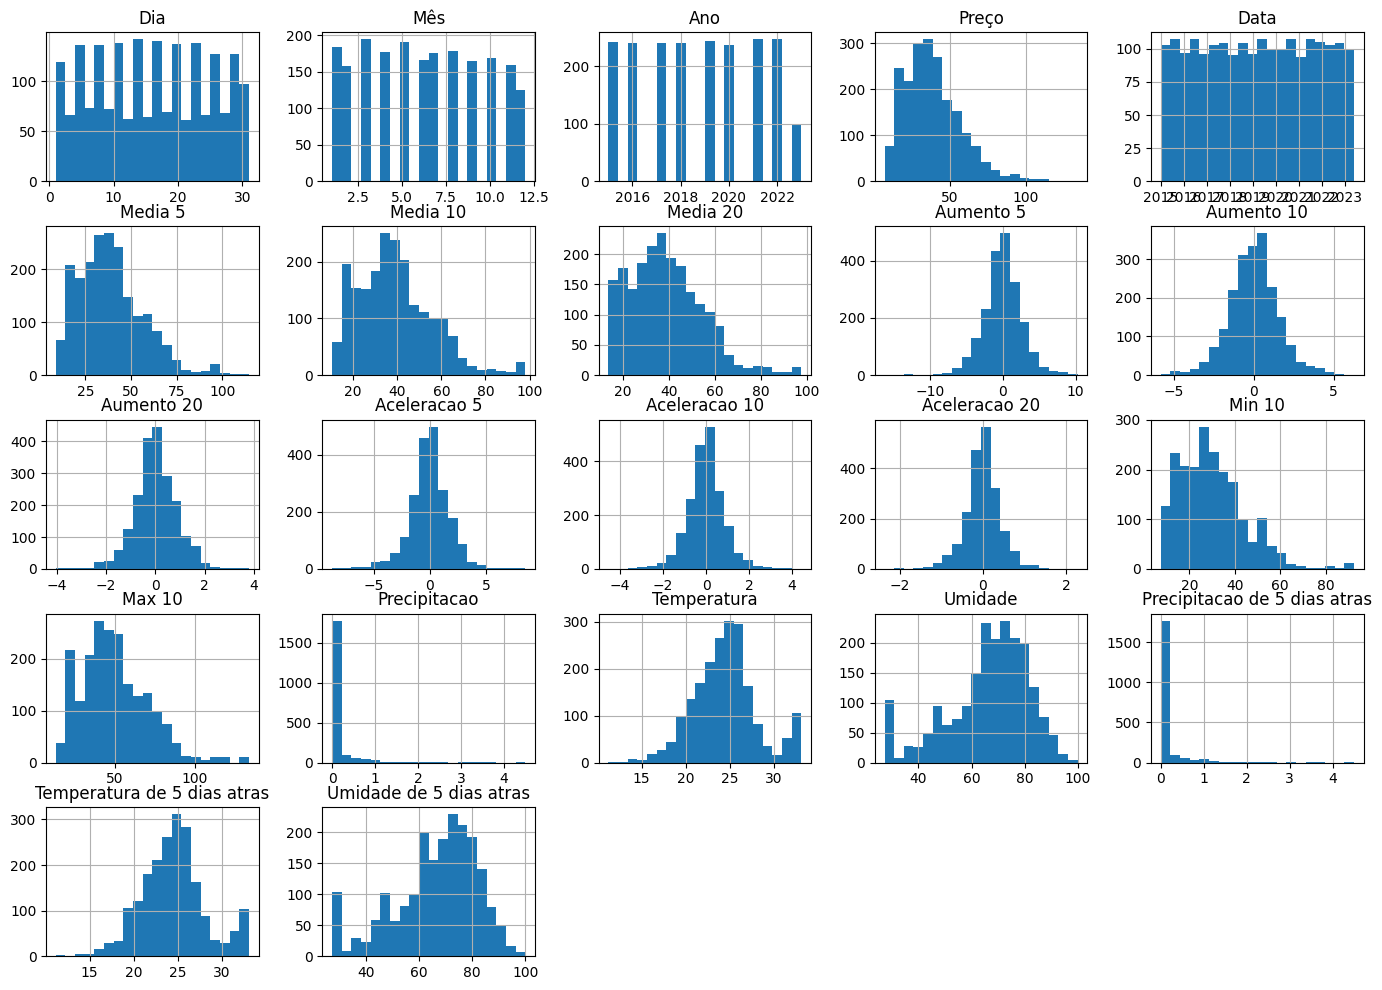

In [163]:
# Histograma das features
df_sp_salada_AA.hist(bins=20, figsize=(17,12))

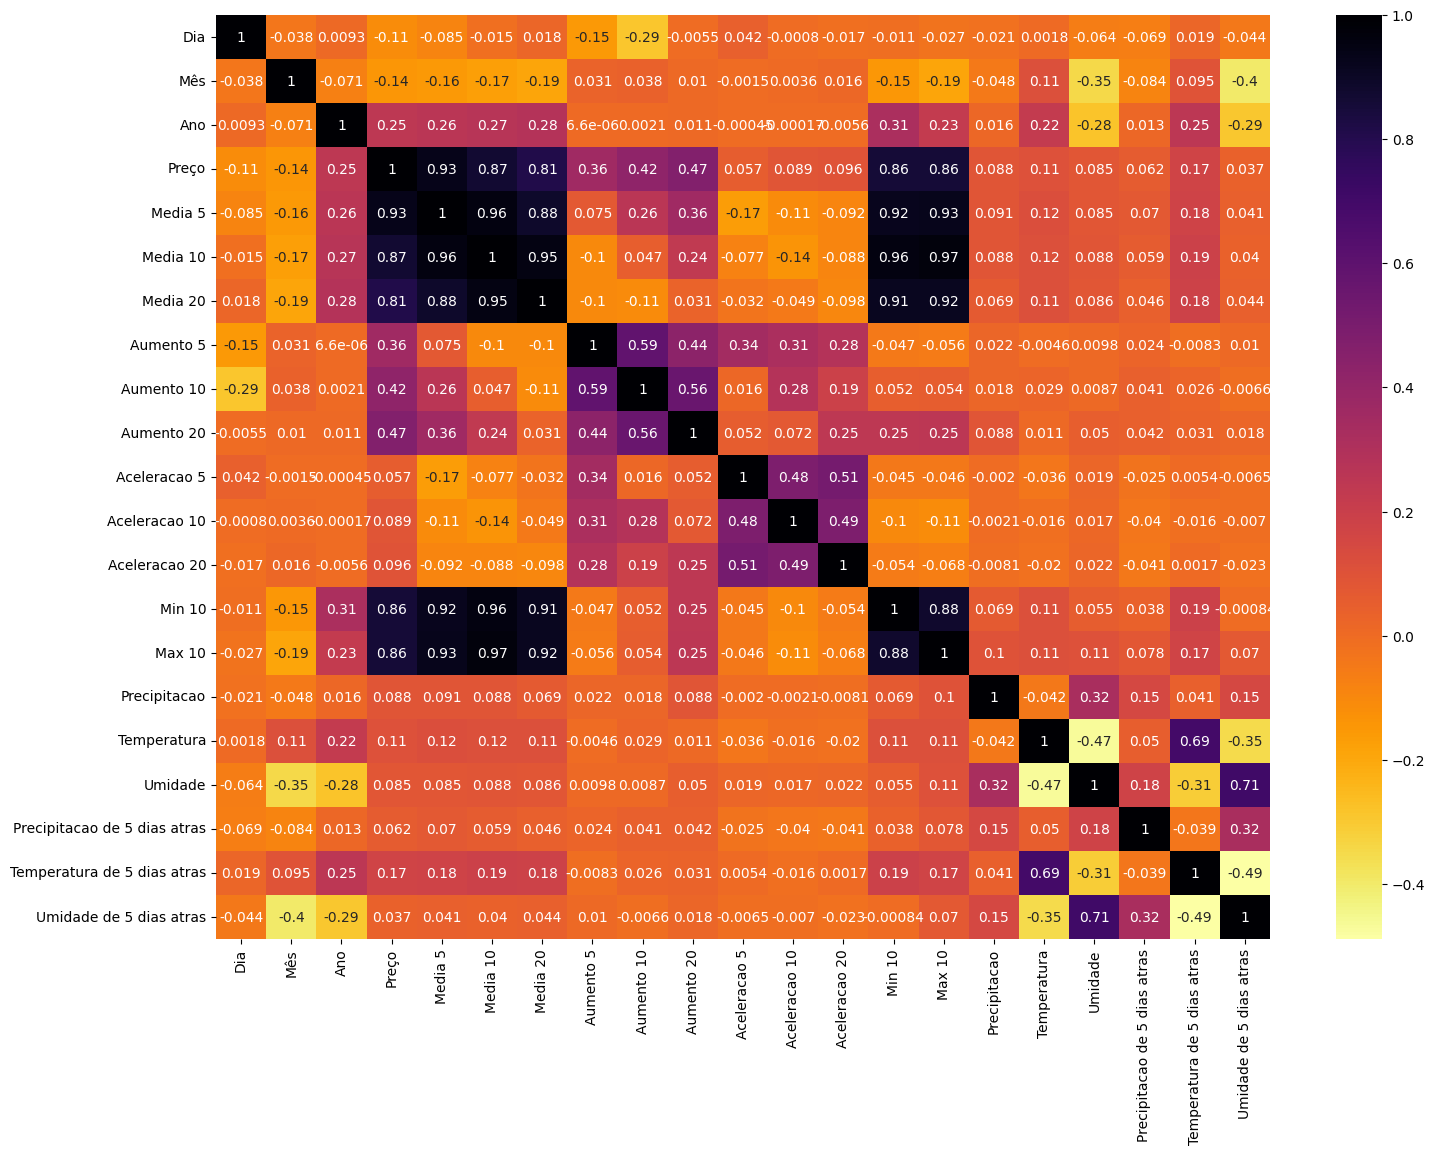

In [164]:
# Matriz de correlação do modelo
plt.figure(figsize=(17,12))
sns.heatmap(df_sp_salada_AA.corr(),annot=True,cmap="inferno_r")
plt.show()

In [165]:
# Seleção das Features utilizadas para o trienamento do modelo
x = df_sp_salada_AA[['Dia',
                   'Mês',
                   'Ano',
                   'Aumento 5',
                   'Aumento 10',
                   'Aumento 20',
                   'Aceleracao 5',
                   'Aceleracao 10',
                   'Aceleracao 20',
                   'Media 5',
                   'Media 10',
                   'Media 20',
                   'Min 10',
                   'Max 10',
                   'Precipitacao',
                   'Temperatura',
                   'Umidade',
                   'Precipitacao de 5 dias atras',
                   'Temperatura de 5 dias atras',
                   'Umidade de 5 dias atras']].values
y= df_sp_salada_AA[['Preço']].values

In [166]:
# Padronização das Escalas das Features do modelo
sc = StandardScaler()
x = sc.fit_transform(x)

In [167]:
# Escolha dos modelos candidatos para o treinamento
from sklearn.model_selection import cross_val_score
models={
 'LinearRegression':LinearRegression(),
 'Lasso':Lasso(),
 'Ridge':Ridge(),
 'GradientBoostingRegressor':GradientBoostingRegressor(),
 'AdaBoostRegressor':AdaBoostRegressor(),
 'RandomForestRegressor':RandomForestRegressor(),
 'KneghborsRegressor':KNeighborsRegressor()
}

In [168]:
# Efetua o teste dos modelos pela Validação cruzada
for name, model in models.items():
    scores=cross_val_score(model,x,y,scoring='neg_mean_squared_error',cv=10,n_jobs=-1)
    print('Modelo avaliado:{}'.format(name))
    rmse=np.sqrt(-scores)
    rmse_avarage=np.mean(rmse)
    print('Média RMSE:',rmse_avarage)
    print('-'*20)

Modelo avaliado:LinearRegression
Média RMSE: 2.2360338239466278
--------------------
Modelo avaliado:Lasso
Média RMSE: 3.150510842541913
--------------------
Modelo avaliado:Ridge
Média RMSE: 2.237591472086721
--------------------
Modelo avaliado:GradientBoostingRegressor
Média RMSE: 3.13586134135598
--------------------
Modelo avaliado:AdaBoostRegressor
Média RMSE: 5.00608511643818
--------------------
Modelo avaliado:RandomForestRegressor
Média RMSE: 3.271670002094684
--------------------
Modelo avaliado:KneghborsRegressor
Média RMSE: 6.708189547341791
--------------------


In [169]:
# Divide os dados em treino e teste, com 80% dos valores para Treino e 20% para teste
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [170]:
# Modelo escolhido de acorco com o desempenho acima
Modelo_Salada_AA = Ridge()

In [171]:
# Treina o modelo de acordo com os dados de Teste
Modelo_Salada_AA.fit(x_train,y_train)

Ridge()

In [172]:
# Calcula as métricas de avaliação do modelo escolhido
training_score = Modelo_Salada_AA.score(x_train, y_train)*100
testing_score = Modelo_Salada_AA.score(x_test, y_test)*100
score = r2_score(y_test, Modelo_Salada_AA.predict(x_test))*100
mae = mean_absolute_error(y_test, Modelo_Salada_AA.predict(x_test))
mse = mean_squared_error(y_test, Modelo_Salada_AA.predict(x_test))
print("Score em Treino: ", training_score)
print("Score em Teste: ", testing_score)
print("Erro Médio Absoluto: ", mae)
print("Erro Médio Quadrático: ", mse)
print("R2score: ",score)


Score em Treino:  98.40955954432759
Score em Teste:  98.49037346615323
Erro Médio Absoluto:  1.6706873496961063
Erro Médio Quadrático:  5.111323702694404
R2score:  98.49037346615323


In [173]:
# Efetua a predição com base na aprendizagem do modelo
y_pred = Modelo_Salada_AA.predict(x)

<Axes: xlabel='Data', ylabel='Erro'>

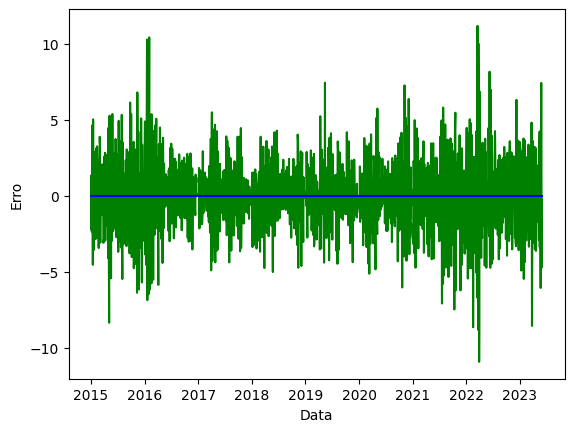

In [174]:
# Adiciona ao Dataframe mais duas colunas uma com o valor predito e outra com a diferença entre a predição e o dado real
df_sp_salada_AA['Preço Predito'] = y_pred
df_sp_salada_AA['Erro'] = df_sp_salada_AA['Preço Predito'] - df_sp_salada_AA['Preço']

# Plota os gráficos conforme as colunas criadas
sns.lineplot(data = df_sp_salada_AA, x="Data", y = "Erro",color="green")
sns.lineplot(data = df_sp_salada_AA, x="Data", y = 0,color="blue")

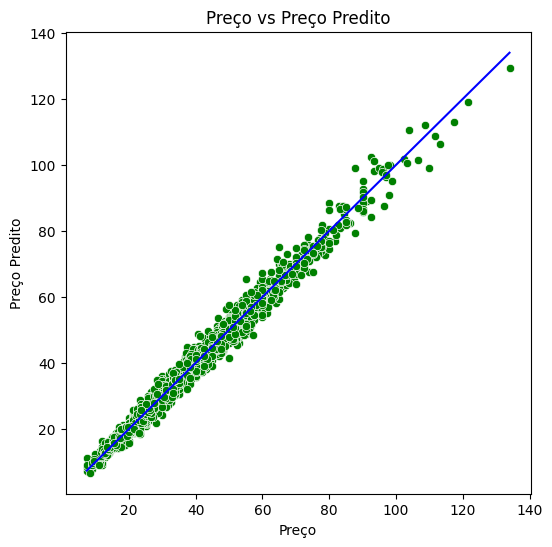

In [175]:
# Plota o gráfico que relaciona os dados preditos com os dados reais
plt.figure(figsize=(6,6))
sns.scatterplot(data = df_sp_salada_AA, x="Preço", y = "Preço Predito",color="green")
sns.lineplot(data = df_sp_salada_AA, x="Preço", y = "Preço",color="blue")
plt.title("Preço vs Preço Predito")
plt.show();

### Tomate Italiano

array([[<Axes: title={'center': 'Dia'}>, <Axes: title={'center': 'Mês'}>,
        <Axes: title={'center': 'Ano'}>,
        <Axes: title={'center': 'Preço'}>,
        <Axes: title={'center': 'Data'}>],
       [<Axes: title={'center': 'Media 5'}>,
        <Axes: title={'center': 'Media 10'}>,
        <Axes: title={'center': 'Media 20'}>,
        <Axes: title={'center': 'Aumento 5'}>,
        <Axes: title={'center': 'Aumento 10'}>],
       [<Axes: title={'center': 'Aumento 20'}>,
        <Axes: title={'center': 'Aceleracao 5'}>,
        <Axes: title={'center': 'Aceleracao 10'}>,
        <Axes: title={'center': 'Aceleracao 20'}>,
        <Axes: title={'center': 'Min 10'}>],
       [<Axes: title={'center': 'Max 10'}>,
        <Axes: title={'center': 'Precipitacao'}>,
        <Axes: title={'center': 'Temperatura'}>,
        <Axes: title={'center': 'Umidade'}>,
        <Axes: title={'center': 'Precipitacao de 5 dias atras'}>],
       [<Axes: title={'center': 'Temperatura de 5 dias atras'}>,
 

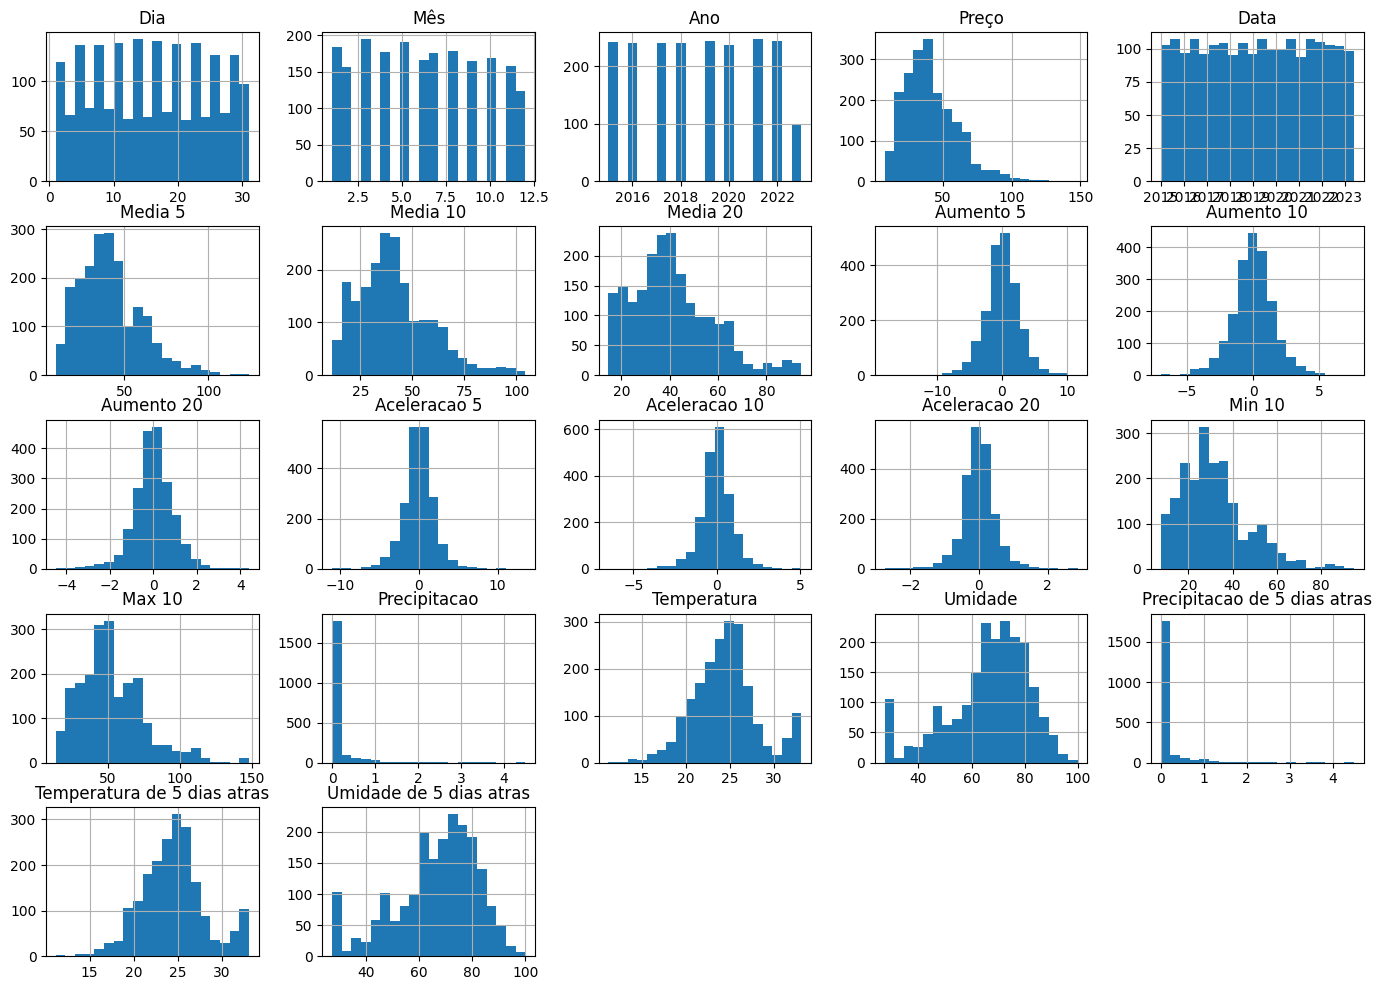

In [177]:
# Histograma das features
df_sp_italiano.hist(bins=20, figsize=(17,12))

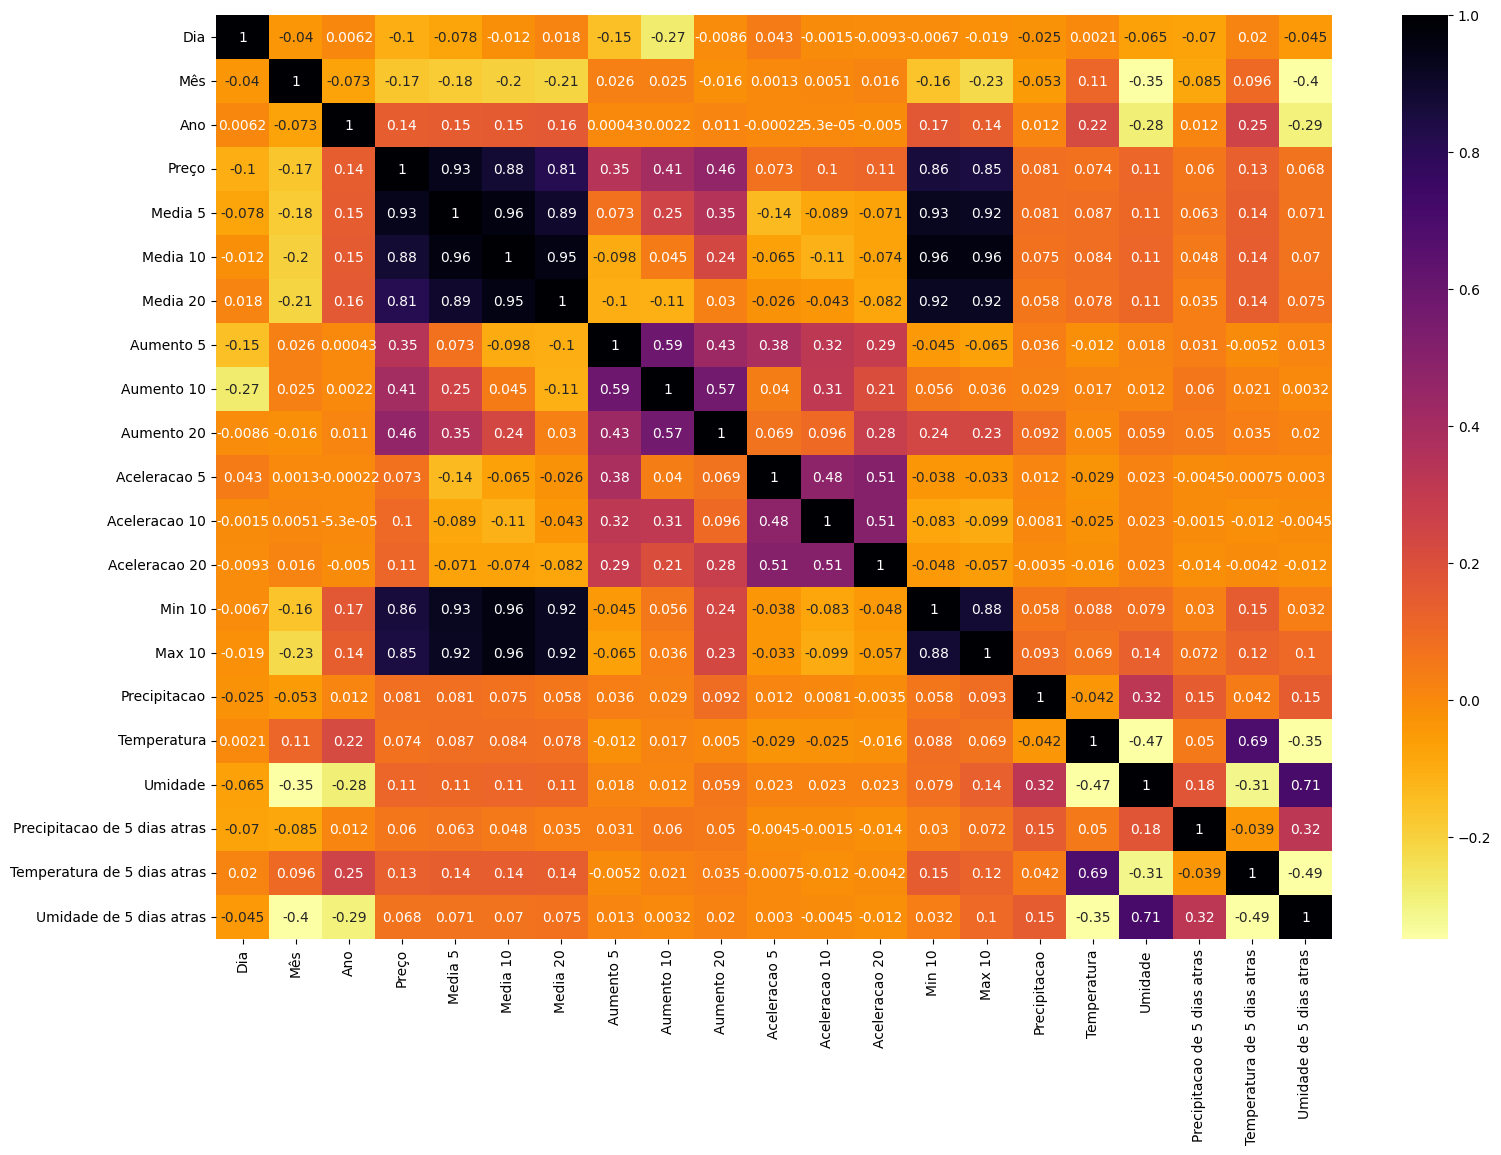

In [178]:
# Matriz de correlação do modelo
plt.figure(figsize=(18,12))
sns.heatmap(df_sp_italiano.corr(),annot=True,cmap="inferno_r",robust=True)
plt.show()

In [179]:
# Seleção das Features utilizadas para o trienamento do modelo
x= df_sp_italiano[['Dia',
                   'Mês',
                   'Ano',
                   'Aumento 5',
                   'Aumento 10',
                   'Aumento 20',
                   'Aceleracao 5',
                   'Aceleracao 10',
                   'Aceleracao 20',
                   'Media 5',
                   'Media 10',
                   'Media 20',
                   'Min 10',
                   'Max 10',
                   'Precipitacao',
                   'Temperatura',
                   'Umidade',
                   'Precipitacao de 5 dias atras',
                   'Temperatura de 5 dias atras',
                   'Umidade de 5 dias atras']].values
y= df_sp_italiano[['Preço']].values

In [180]:
# Padronização das Escalas das Features do modelo
sc = StandardScaler()
x = sc.fit_transform(x)

In [181]:
# Escolha dos modelos candidatos para o treinamento
from sklearn.model_selection import cross_val_score
models={
 'LinearRegression':LinearRegression(),
 'Lasso':Lasso(),
 'Ridge':Ridge(),
 'GradientBoostingRegressor':GradientBoostingRegressor(),
 'AdaBoostRegressor':AdaBoostRegressor(),
 'RandomForestRegressor':RandomForestRegressor(),
 'KneghborsRegressor':KNeighborsRegressor()
}

In [182]:
# Efetua o teste dos modelos pela Validação cruzada
for name, model in models.items():
 scores=cross_val_score(model,x,y,scoring='neg_mean_squared_error',cv=10,n_jobs=-1)
 print('ss validaton model:{}'.format(name))
 rmse=np.sqrt(-scores)
 rmse_avarage=np.mean(rmse)
 print('AVARAGE RMSE:',rmse_avarage)
 print('-'*20)


ss validaton model:LinearRegression
AVARAGE RMSE: 2.4969971452842525
--------------------
ss validaton model:Lasso
AVARAGE RMSE: 3.3479667345093227
--------------------
ss validaton model:Ridge
AVARAGE RMSE: 2.499045618391165
--------------------
ss validaton model:GradientBoostingRegressor
AVARAGE RMSE: 3.4345010070284645
--------------------
ss validaton model:AdaBoostRegressor
AVARAGE RMSE: 5.135735909849007
--------------------
ss validaton model:RandomForestRegressor
AVARAGE RMSE: 3.558831237296912
--------------------
ss validaton model:KneghborsRegressor
AVARAGE RMSE: 6.778704271502518
--------------------


In [183]:
# Divide os dados em treino e teste, com 80% dos valores para Treino e 20% para teste
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [184]:
# Modelo escolhido de acorco com o desempenho acima
Modelo_Italiano = LinearRegression()

In [185]:
# Treina o modelo de acordo com os dados de Teste
Modelo_Italiano.fit(x_train,y_train)

LinearRegression()

In [186]:
# Calcula as métricas de avaliação do modelo escolhido
training_score = Modelo_Italiano.score(x_train, y_train)*100
testing_score = Modelo_Italiano.score(x_test, y_test)*100
score = r2_score(y_test, Modelo_Italiano.predict(x_test))*100
mae = mean_absolute_error(y_test, Modelo_Italiano.predict(x_test))
mse = mean_squared_error(y_test, Modelo_Italiano.predict(x_test))
print("R2score: ",score)
print("Score em Treino: ", training_score)
print("Score em Teste: ", testing_score)
print("Erro Médio Absoluto: ", mae)
print("Erro Médio Quadrático: ", mse)

R2score:  98.14134947069864
Score em Treino:  98.21766804378963
Score em Teste:  98.14134947069864
Erro Médio Absoluto:  1.8765192112046623
Erro Médio Quadrático:  6.746804977767622


In [187]:
# Efetua a predição com base na aprendizagem do modelo
y_pred = Modelo_Italiano.predict(x)

<Axes: xlabel='Data', ylabel='Erro'>

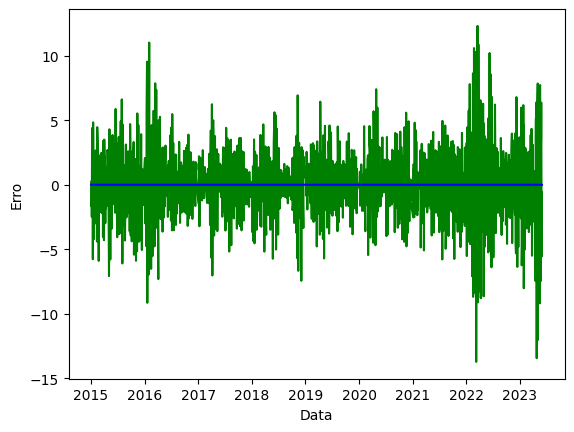

In [188]:
# Adiciona ao Dataframe mais duas colunas uma com o valor predito e outra com a diferença entre a predição e o dado real
df_sp_italiano['Preço Predito'] = y_pred
df_sp_italiano['Erro'] = df_sp_italiano['Preço Predito'] - df_sp_italiano['Preço']
# Plota os gráficos conforme as colunas criadas
sns.lineplot(data = df_sp_italiano, x="Data", y = "Erro",color="green")
sns.lineplot(data = df_sp_italiano, x="Data", y = 0,color="blue")

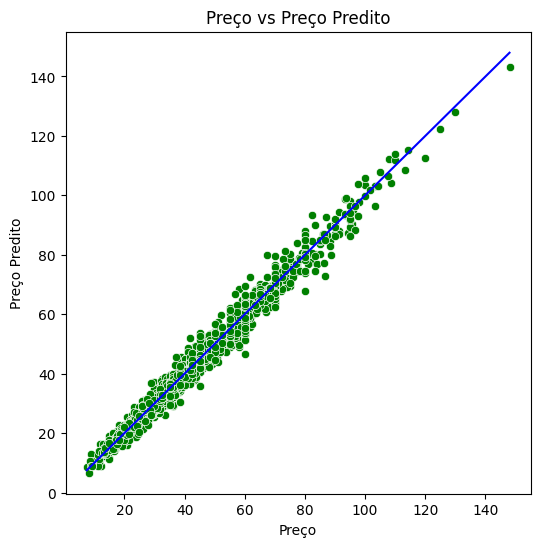

In [189]:
# Plota o gráfico que relaciona os dados preditos com os dados reais
plt.figure(figsize=(6,6))
sns.scatterplot(data = df_sp_italiano, x="Preço", y = "Preço Predito",color="green")
sns.lineplot(data = df_sp_italiano, x="Preço", y = "Preço",color="blue")
plt.title("Preço vs Preço Predito")
plt.show();